In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [3]:
#Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

data_dir = 'antbee_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                 for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\user\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


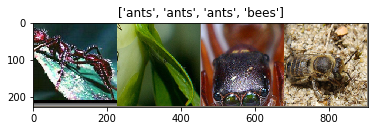

In [4]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp,title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
#Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() #Set model to training mode
            else:
                model.eval() #Set model to evaluate mode
                
            running_loss=0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad() #zero the parameter gradientss 역전파 단계 실행전에 변화도 0으로 만들기
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels) # 손실계산
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:.4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
#Visualizing the model predictions
#Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images //2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    

In [7]:
# 사전 훈련 된 모델을로드하고 최종 완전 연결 계층을 재설정합니다.
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# 모든 매개 변수가 최적화되고 있는지 관찰하십시오.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 epoch마다 0.1의 계수로 LR 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [9]:
#It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5428 Acc: 0.7664
val Loss: 0.2148 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.3896 Acc: 0.8320
val Loss: 0.1771 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.7088 Acc: 0.7664
val Loss: 0.3879 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.5877 Acc: 0.7787
val Loss: 0.3355 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4318 Acc: 0.8074
val Loss: 0.3097 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5103 Acc: 0.8238
val Loss: 0.4225 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4518 Acc: 0.8484
val Loss: 0.2505 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2851 Acc: 0.8770
val Loss: 0.2500 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2970 Acc: 0.8730
val Loss: 0.2584 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3406 Acc: 0.8566
val Loss: 0.2394 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3204 Acc: 0.8770
val Loss: 0.3095 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.2841 Acc: 0.8566
val Loss: 0.2249 Acc: 0.9281

Ep

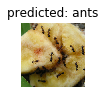

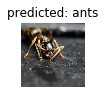

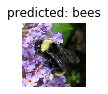

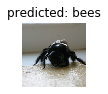

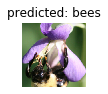

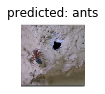

In [10]:
visualize_model(model_ft)

In [11]:
#ConvNet as fixed feature extractor
# 최종 레이어를 제외한 모든 네트워크를 동결해야함
#그래디언트가 backward ()에서 계산되지 않도록 매개 변수를 고정하려면 requires_grad == False를 설정해야함

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6753 Acc: 0.6680
val Loss: 0.2814 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.4908 Acc: 0.7664
val Loss: 0.1819 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.6205 Acc: 0.7377
val Loss: 0.1670 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.6204 Acc: 0.7623
val Loss: 0.2032 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5953 Acc: 0.7623
val Loss: 0.2735 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5166 Acc: 0.7869
val Loss: 0.1887 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4057 Acc: 0.8115
val Loss: 0.1747 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.2724 Acc: 0.8852
val Loss: 0.1791 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.4235 Acc: 0.8033
val Loss: 0.2191 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3548 Acc: 0.8525
val Loss: 0.2062 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3417 Acc: 0.8770
val Loss: 0.1796 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3289 Acc: 0.8689
val Loss: 0.1958 Acc: 0.9412

Ep

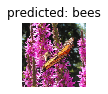

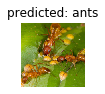

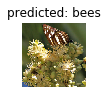

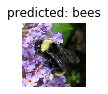

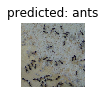

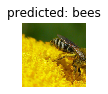

In [13]:
visualize_model(model_conv)
plt.ioff()
plt.show()